## Projects:

- Diffusion Models;
- YOLO versions  - object detection;
- Segment Anything Model (https://segment-anything.com/) (Liked);
- Mathematical Integration;
- BERT fine-tuning - Text classification (compare with logistic regression and TF-IDF vectors);
- CNN visualization - review the different techniques used to analyze CNN predictions;
- Monte Carlo dropout - review briefly the concept of uncertainty and what are the main techniques used to deal with uncertainty in deep learning;
- Deep vs Wide Neural Networks - Try to understand the effect of adding layers or adding parameters in a layer;
- Overparameterization regime;
- Neural ODEs - Neural Networks and ordinary differential equations are the two main modelization techniques used nowadays, review papers explaining some evolution of the idea of Neural ODE.

General observations:

- Presentation of 15 min 
- 70% grade
- No need to submit the code

Evaluation aspects:

- Clarity
- Understanding of concepts
- Depth of research and/or experiments

In [2]:
import torch
import numpy as np
#import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import glob

# Load SAM model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Elisa's SAM Model
sam = sam_model_registry["vit_h"](checkpoint="C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/sam_vit_h_4b8939.pth").to(device)
#Victor's SAM Model
#sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device)
predictor = SamPredictor(sam)
print("✅ SAM Model loaded successfully!")



✅ SAM Model loaded successfully!


Eli Vic and Ale folder path

VIC
/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Cropped_Tumors/val
/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/cropped_segments

ELI
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/sam_vit_h_4b8939.pth
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images/
C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Breast_Images

ALE

To train a CNN for tumor classification (benign, malignant, normal), we will:

Prepare the dataset by splitting images into training (80%) and validation (20%).
Use a CNN architecture  
Train the model using TensorFlow

In [4]:
# Define dataset paths
#dataset_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/Cropped_Tumors"
# Victor's dataset path
dataset_dir = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/Cropped_Tumors"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")

# Create lists to store data for DataFrame
data_records = []

# Split dataset into train (80%) and validation (20%) if not already done
if not os.path.exists(train_dir) or not os.path.exists(val_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for category in ["benign", "malignant", "normal"]:
        images = np.array(glob.glob(os.path.join(dataset_dir, category, "*.png")))  # Convert to NumPy array
        indices = np.arange(len(images))  # Store indices

        train_images, val_images, train_idx, val_idx = train_test_split(
            images, indices, test_size=0.2, random_state=42
        )

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        # Store training images
        for img, idx in zip(train_images, train_idx):
            shutil.copy(img, os.path.join(train_dir, category, os.path.basename(img)))
            data_records.append({"filename": os.path.basename(img), "category": category, "split": "train", "index": idx})

        # Store validation images
        for img, idx in zip(val_images, val_idx):
            shutil.copy(img, os.path.join(val_dir, category, os.path.basename(img)))
            data_records.append({"filename": os.path.basename(img), "category": category, "split": "val", "index": idx})

# Create DataFrame
df = pd.DataFrame(data_records)



In [11]:
val_df = df[df['split'] == 'val']
print(val_df)


KeyError: 'split'

In [14]:
val_df.to_csv("validation_images.csv", index=False)


In [ ]:
# Image preprocessing
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# Define CNN model (similar to your example)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same",
                                 input_shape=(128, 128, 3)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))  # 3 classes: benign, malignant, normal

# Compile model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()



Found 974 images belonging to 3 classes.
Found 245 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32,

I use 5 epochs to see if it works for the moment, we should do 20

Epoch 1/5
31/31 [==============================] - 16s 511ms/step - loss: 0.4337 - accuracy: 0.8255 - val_loss: 0.3613 - val_accuracy: 0.8857
Epoch 2/5
31/31 [==============================] - 15s 489ms/step - loss: 0.3750 - accuracy: 0.8645 - val_loss: 0.3628 - val_accuracy: 0.8898
Epoch 3/5
31/31 [==============================] - 15s 471ms/step - loss: 0.2927 - accuracy: 0.8912 - val_loss: 0.2861 - val_accuracy: 0.9143
Epoch 4/5
31/31 [==============================] - 15s 472ms/step - loss: 0.2674 - accuracy: 0.9097 - val_loss: 0.3150 - val_accuracy: 0.8857
Epoch 5/5
31/31 [==============================] - 15s 489ms/step - loss: 0.2193 - accuracy: 0.9261 - val_loss: 0.4796 - val_accuracy: 0.8898


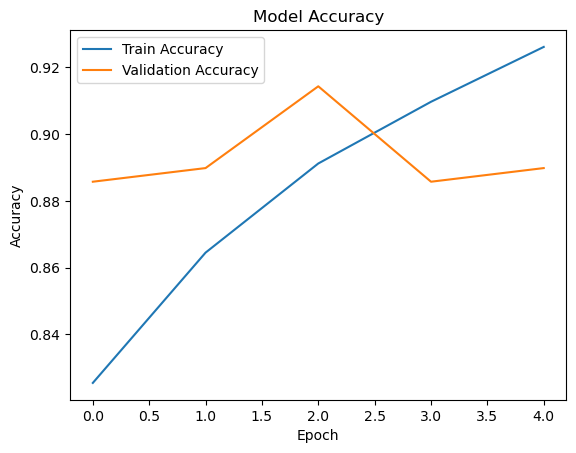

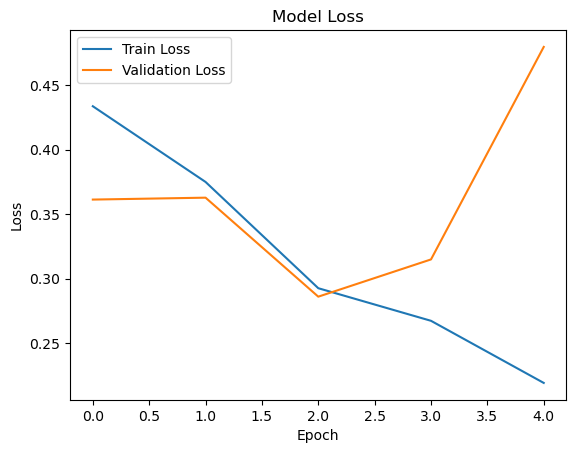

8/8 [==============================] - 2s 186ms/step - loss: 0.4796 - accuracy: 0.8898
Validation Loss: 0.4796
Validation Accuracy: 0.8898


In [11]:

# Train model
epochs = 5
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# Save model
model.save("tumor_classifier.h5")

# Function to plot accuracy
def accuracy_plot(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train Accuracy", "Validation Accuracy"], loc="upper left")
    plt.show()

# Function to plot loss
def loss_plot(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train Loss", "Validation Loss"], loc="upper left")
    plt.show()

# Plot accuracy and loss
accuracy_plot(history)
loss_plot(history)

# Evaluate model on validation set
score = model.evaluate(val_generator)
print("Validation Loss: {:.4f}".format(score[0]))
print("Validation Accuracy: {:.4f}".format(score[1]))

# Interpreting CNN Training Results

## 1. Key Observations

- **Model is learning well**: Training accuracy steadily increased from 82.55% to 92.61%.
- **Validation accuracy peaked at epoch 3**: 91.43%, then slightly decreased.
- **Validation loss initially decreased but increased at the end**, suggesting possible overfitting.



Question for my boys:

- should we train on the full set of cropped images given that we should test the CNN on the full image vs the SAM segmented images?
- we might have overfitting. stop at Epoch 3? Increase Dropout? Lower the Learning Rate? Add More Data Augmentation eg 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

## 2 Using Trained Model on SAM Segmented Images

In [3]:
import tensorflow as tf

# Load trained Keras model
model = tf.keras.models.load_model("tumor_classifier.h5")


#### Single Image

In [7]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load image
#Elisa path
img_path = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments/benign/benign (1)_segment_4.png"

#Victor path
#img_path = "/home/sobottka/BSE/2nd_Term/Computational Learning and Deep Learning/Final_Project/Deep_Learning_FinalProject/cropped_segments/benign/benign (1)_segment_11.png"
img = image.load_img(img_path, target_size=(128, 128))  # Resize
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 131ms/step
Predicted class: 1


#### Multiple Images

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "dataset/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [13]:
#Elisa code 

import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

# Define the base directory containing the folders
base_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments_tumors/"

# Create a list to store the results
results = []

# Loop through both "benign" and "malignant" folders
for category in ["benign", "malignant"]:
    category_path = os.path.join(base_dir, category)

    if not os.path.exists(category_path):
        print(f"Skipping {category}, folder not found.")
        continue  # Skip if folder does not exist

    # Iterate over images in the category folder
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)

        try:
            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(128, 128))  # Resize
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Store results
            results.append({
                "Image": img_file,
                "Category": category,
                "Predicted Class": predicted_class
            })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df.head())

1/1 [==============================] - 0s 22ms/step
                              Image Category  Predicted Class
0  benign (1)_segment_12_normal.png   benign                2
1  benign (1)_segment_14_normal.png   benign                2
2  benign (1)_segment_17_normal.png   benign                2
3  benign (1)_segment_18_normal.png   benign                2
4  benign (1)_segment_19_normal.png   benign                2


In [14]:
#predicted class is: 2 normal, 1 malignant and 0 benign
results_df

,Image,Category,Predicted Class
0,benign (1)_segment_12_normal.png,benign,2
1,benign (1)_segment_14_normal.png,benign,2
2,benign (1)_segment_17_normal.png,benign,2
3,benign (1)_segment_18_normal.png,benign,2
4,benign (1)_segment_19_normal.png,benign,2
...,...,...,...
1120,malignant (95)_segment_31_normal.png,malignant,2
1121,malignant (95)_segment_32_normal.png,malignant,2
1122,malignant (95)_segment_40_normal.png,malignant,0
1123,malignant (95)_segment_6_tumor.png,malignant,2


In [20]:
# Function to assign new column values based on conditions
def classify_image(row):
    if row['Category'] == 'benign' and row['Image'].endswith('_tumor.png'):
        return 0
    elif row['Category'] == 'malignant' and row['Image'].endswith('_tumor.png'):
        return 1
    elif row['Image'].endswith('_normal.png'):
        return 2
    return None  # This covers unexpected cases if needed

# Apply the function to create the new column
results_df['Actual Class'] = results_df.apply(classify_image, axis=1)
results_df

,Image,Category,Predicted Class,Actual Class
0,benign (1)_segment_12_normal.png,benign,2,2
1,benign (1)_segment_14_normal.png,benign,2,2
2,benign (1)_segment_17_normal.png,benign,2,2
3,benign (1)_segment_18_normal.png,benign,2,2
4,benign (1)_segment_19_normal.png,benign,2,2
...,...,...,...,...
1120,malignant (95)_segment_31_normal.png,malignant,2,2
1121,malignant (95)_segment_32_normal.png,malignant,2,2
1122,malignant (95)_segment_40_normal.png,malignant,0,2
1123,malignant (95)_segment_6_tumor.png,malignant,2,1


In [ ]:
#adding actual class label so that we can check accuracy of prediction
# Define the base directory containing the folders
base_dir = "C:/Users/elisa/OneDrive/Desktop/Deep Learning/DL_Project/Deep_Learning_FinalProject/cropped_segments_tumors/"

# Create a list to store the results
results = []

# Function to classify images based on filename and category
def classify_image(row):
    if row['Category'] == 'benign' and row['Image'].endswith('_tumor.png'):
        return 0
    elif row['Category'] == 'malignant' and row['Image'].endswith('_tumor.png'):
        return 1
    elif row['Image'].endswith('_normal.png'):
        return 2
    return None  # Handle unexpected cases

# Loop through both "benign" and "malignant" folders
for category in ["benign", "malignant"]:
    category_path = os.path.join(base_dir, category)

    if not os.path.exists(category_path):
        print(f"Skipping {category}, folder not found.")
        continue  # Skip if folder does not exist

    # Iterate over images in the category folder
    for img_file in os.listdir(category_path):
        img_path = os.path.join(category_path, img_file)

        try:
            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(128, 128))  # Resize
            img_array = image.img_to_array(img) / 255.0  # Normalize
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions)

            # Store results
            results.append({
                "Image": img_file,
                "Category": category,
                "Predicted Class": predicted_class
            })

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Apply the classify_image function to create the Actual Class column
results_df["Actual Class"] = results_df.apply(classify_image, axis=1)



1/1 [==============================] - 0s 38ms/step


Exception ignored in: <function UniquePtr.__del__ at 0x000001F507570550>
Traceback (most recent call last):
  File "c:\Users\elisa\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: _obj


1/1 [==============================] - 0s 20ms/step
Model Accuracy: 85.24%


In [22]:
results_df

,Image,Category,Predicted Class,Actual Class
0,benign (1)_segment_12_normal.png,benign,2,2
1,benign (1)_segment_14_normal.png,benign,2,2
2,benign (1)_segment_17_normal.png,benign,2,2
3,benign (1)_segment_18_normal.png,benign,2,2
4,benign (1)_segment_19_normal.png,benign,2,2
...,...,...,...,...
1120,malignant (95)_segment_31_normal.png,malignant,2,2
1121,malignant (95)_segment_32_normal.png,malignant,2,2
1122,malignant (95)_segment_40_normal.png,malignant,0,2
1123,malignant (95)_segment_6_tumor.png,malignant,2,1


In [23]:
accuracy = (results_df["Predicted Class"] == results_df["Actual Class"]).mean()
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 85.24%


### Compute Precision, Recall, and F1-Score

In [24]:
from sklearn.metrics import classification_report, accuracy_score

# Compute classification report
report = classification_report(results_df["Actual Class"], results_df["Predicted Class"], digits=4)

# Compute accuracy
accuracy = accuracy_score(results_df["Actual Class"], results_df["Predicted Class"])

print(f"Model Accuracy: {accuracy:.2%}")
print("\nClassification Report:\n", report)


Model Accuracy: 85.24%

Classification Report:
               precision    recall  f1-score   support

           0     0.4590    0.2353    0.3111       119
           1     0.2941    0.1163    0.1667        43
           2     0.8844    0.9616    0.9214       963

    accuracy                         0.8524      1125
   macro avg     0.5459    0.4377    0.4664      1125
weighted avg     0.8169    0.8524    0.8280      1125



Model Accuracy: 85.24%


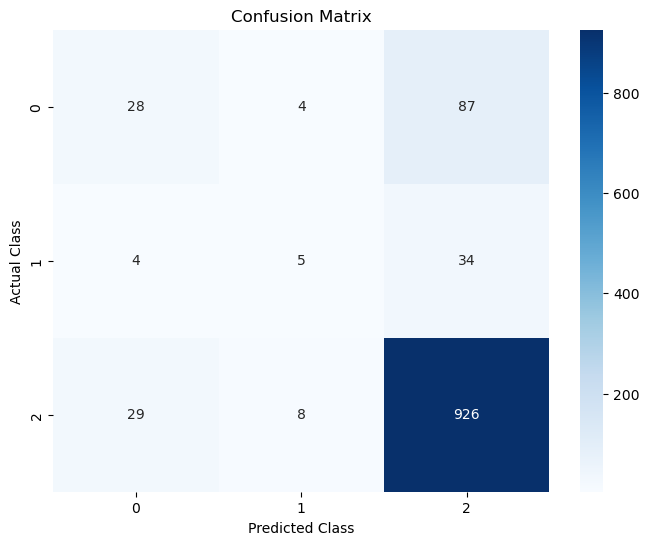

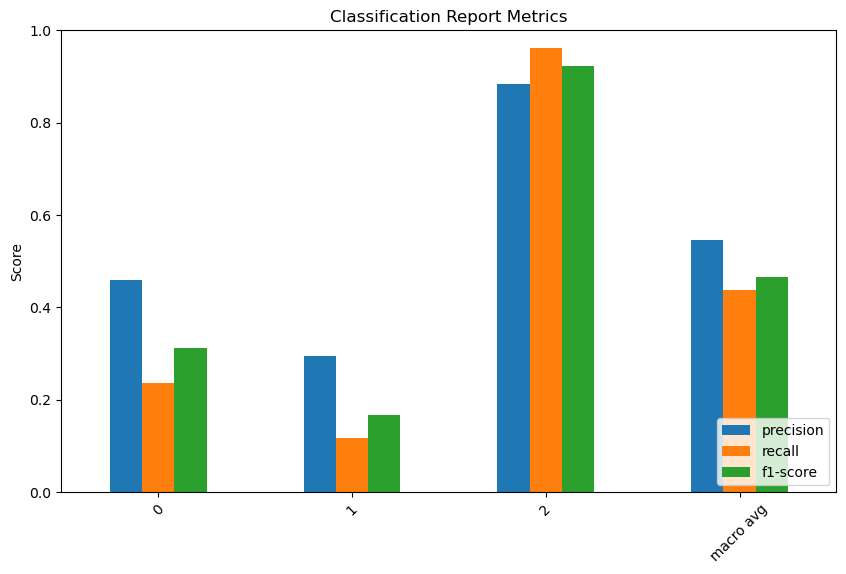

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Compute classification report
report = classification_report(results_df["Actual Class"], results_df["Predicted Class"], output_dict=True)

# Compute accuracy
accuracy = accuracy_score(results_df["Actual Class"], results_df["Predicted Class"])

print(f"Model Accuracy: {accuracy:.2%}")

# Plot confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(results_df["Actual Class"], results_df["Predicted Class"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(results_df["Actual Class"]), yticklabels=set(results_df["Actual Class"]))
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(report).transpose().drop(['accuracy'], errors='ignore')

# Plot precision, recall, and f1-score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10,6))
plt.title("Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


# Classification Results Analysis

## 1. Overall Accuracy (85.24%)

The model correctly classifies a large proportion of images, but accuracy alone is misleading in imbalanced datasets.
Since the dataset is dominated by normal images (class 2), the model could achieve high accuracy just by predicting most images as normal, without truly learning to recognize tumors.

## 2. Per-Class Performance

### Class 0 (Tumor Type 1)
- **Precision**: 0.4590 (45.9%) → When the model predicts class 0, it is correct only 45.9% of the time.
- **Recall**: 0.2353 (23.5%) → The model detects only 23.5% of actual tumors in class 0.
- **F1-score**: 0.3111 → The harmonic mean of precision and recall is low, meaning the model is struggling to detect class 0 tumors.

### Class 1 (Tumor Type 2)
- **Precision**: 0.2941 (29.4%) → When the model predicts class 1, it is correct only 29.4% of the time.
- **Recall**: 0.1163 (11.6%) → The model misses most tumors in class 1, detecting only 11.6% of them.
- **F1-score**: 0.1667 → The model is performing very poorly for class 1 tumors.

### Class 2 (Normal)
- **Precision**: 0.8844 (88.4%) → When the model predicts "normal," it is correct most of the time.
- **Recall**: 0.9616 (96.2%) → The model correctly identifies normal cases almost always.
- **F1-score**: 0.9214 → Very strong performance for normal images.

## 3. Macro and Weighted Averages

### Macro avg
- **Precision**: 0.5459
- **Recall**: 0.4377
- **F1-score**: 0.4664
- These are averages across all classes without weighting by class size.
- Low recall (43.77%) suggests the model is missing many tumors.

### Weighted avg
- **Precision**: 0.8169
- **Recall**: 0.8524
- **F1-score**: 0.8280
- These averages weight by class frequency.
- The high values here do not reflect true tumor detection performance because class 2 dominates.

## Key Issues

- The model is biased toward classifying images as normal (class 2).
- Low recall for tumor classes (0 and 1) means the model is missing many actual tumors, which is dangerous in medical applications.
- The model struggles to correctly classify tumors when it does predict them (low precision for classes 0 and 1).

## Next Steps: How to Improve the Model

### 1. Address Class Imbalance
- **Use data augmentation** (rotate, flip, zoom tumor images) to artificially increase tumor samples.
- **Try oversampling** (SMOTE) or **undersampling** normal images to balance the dataset.
- **Class-weighted loss function**: Assign higher loss penalties for misclassifying tumor images.


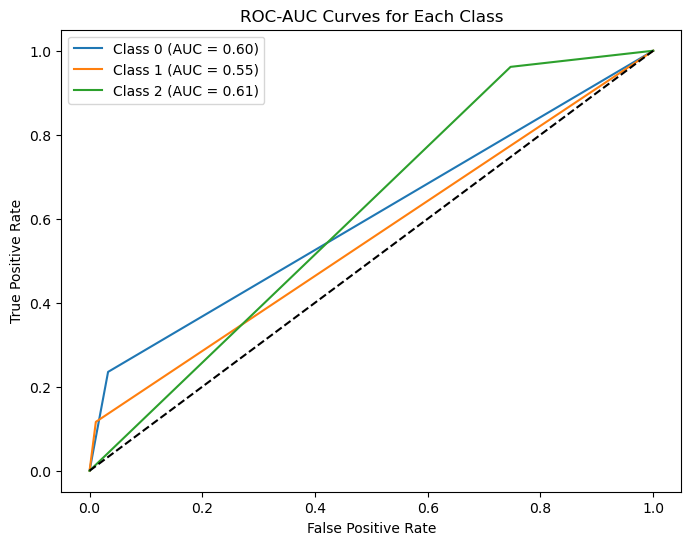

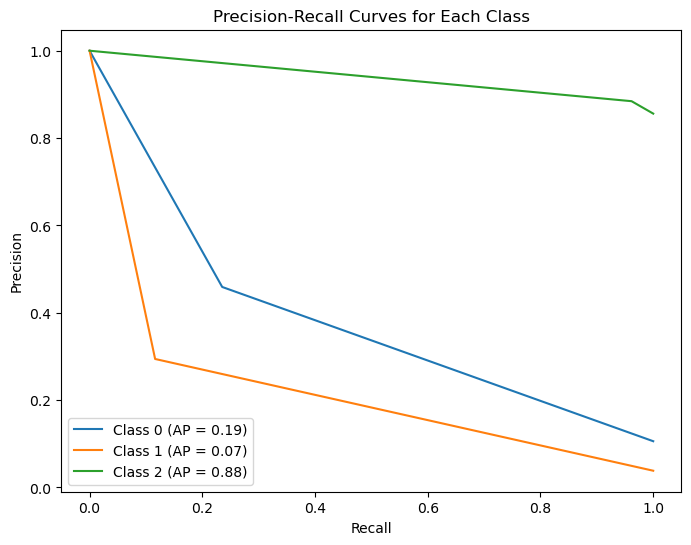

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the actual class labels for multi-class ROC-AUC
classes = sorted(results_df["Actual Class"].unique())  # Get class labels
y_true = label_binarize(results_df["Actual Class"], classes=classes)
y_pred_proba = label_binarize(results_df["Predicted Class"], classes=classes)

# === Plot ROC-AUC Curve for Each Class ===
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curves for Each Class")
plt.legend()
plt.show()

# === Plot Precision-Recall Curve for Each Class ===
plt.figure(figsize=(8,6))
for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP = {avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend()
plt.show()


# Interpretation of the Precision-Recall (PR) Curves

Precision-Recall (PR) curves are crucial when dealing with imbalanced datasets, as they help determine how well your model balances precision (low false positives) and recall (low false negatives).

## Key Takeaways from Your PR Curves

### Class 0 (Tumor Type 1) - AP = 0.19
→ **Poor performance**. The model is struggling to detect these tumors, as precision drops rapidly when recall increases.

### Class 1 (Tumor Type 2) - AP = 0.07
→ **Worst performance**. The model barely detects these tumors, meaning many go undetected (low recall) and when detected, they're often wrong (low precision).

### Class 2 (Normal) - AP = 0.88
→ **High performance**. The model correctly identifies normal images with high confidence.

## Key Issues

### Tumor Detection is Very Poor:
- Precision for tumors drops sharply when recall increases.
- The model favors high precision but low recall, meaning it only detects tumors when it’s very confident, but misses most.

### Imbalance is Hurting Performance:
- The model heavily prioritizes normal images, leading to severe misclassification of tumors.
- AP (Average Precision) for class 1 is almost 0, which is a major issue.

## Combining Insights from ROC-AUC and PR Curves
- **Low AUC (≈0.5-0.6 for tumors) + Low AP (≈0.07-0.19 for tumors)** → The model is essentially guessing when classifying tumors.
- **High AUC & AP for Normal Images** → The model relies too much on predicting "normal" to maximize accuracy.
